# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
### STUDENT START ###
def P1(num_examples=5):
    for i in range(num_examples):
        print '\n------------------------ training example #%d ' %(i+1) + '--------------------------------'
        print 'label number %d - label name: '  %(train_labels[i]) + newsgroups_train.target_names[train_labels[i]]
        print train_data[i]
    print '\n------------------------ End of P1 --------------------------------\n'
### STUDENT END ###

P1(5)



------------------------ training example #1 --------------------------------
label number 1 - label name: comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

------------------------ training example #2 --------------------------------
label number 3 - label name: talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bun

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:

### STUDENT START ###

def P2():
    print '\n------------------ Part a: vocabulary stats ------------------'
    uniVectorizer = CountVectorizer()
    docTermMatrix = uniVectorizer.fit_transform(train_data)    
    print 'size of the vocabulary: %d' %(docTermMatrix.shape[1])
    print 'average number of non-zero features per example: %2f' %(np.mean([doc.nnz for doc in docTermMatrix]))
    print 'fraction of the non-zero entries in the matrix: %2f' %(1.0*docTermMatrix.nnz/np.prod(docTermMatrix.shape))
    
    print '\n------------------ Part b: feature strings ------------------'
    featureNames = uniVectorizer.get_feature_names()
    print '0th feature string: ' + featureNames[0]
    print 'last feature string: ' + featureNames[-1]
    
    print '\n------------------ Part c: manual vocabulary ------------------'  
    # set 4-word vocabulary and re-fit
    uniVectorizer = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    docTermMatrix = uniVectorizer.transform(train_data)    
    # check shape of the new document-term matrix
    print 'new dimension: [%d x %d]' %(docTermMatrix.shape[0], docTermMatrix.shape[1])
    # average number of non-zero features per example
    print 'average number of non-zero features per example: %2f' %(np.mean([doc.nnz for doc in docTermMatrix]))
    
    print '\n------------------ Part d: bigram and trigram char feature ------------------'
    biVectorizer = CountVectorizer(analyzer='char', ngram_range=(2,2))    
    biVectorizer.fit(train_data)
    print 'size of vocabulary for bigram feature: %d' %len(biVectorizer.get_feature_names())    
    triVectorizer = CountVectorizer(analyzer='char', ngram_range=(3,3))
    triVectorizer.fit(train_data)
    print 'size of vocabulary for trigram feature: %d' %len(triVectorizer.get_feature_names())
    
    print '\n------------------ Part e: with min_df = 10 ------------------'
    uniVectorizer = CountVectorizer(min_df=10)
    uniVectorizer.fit(train_data)
    print 'size of vocabulary for unigram feature: %d' %(len(uniVectorizer.get_feature_names()))
        
    print '\n------------------ Part f: vocabulary discrepancy ------------------'
    vectorizer = CountVectorizer()
    vectorizer.fit(train_data)
    trainFeatures = vectorizer.get_feature_names()
    vectorizer.fit(dev_data)
    testFeatures = vectorizer.get_feature_names()
    commonFeatures = list(set(trainFeatures) & set(testFeatures))
    print 'Percentage of dev words missing in vocabulary: %2f' %(1.0*(len(testFeatures)-len(commonFeatures))/len(testFeatures))
    
#### STUDENT END ###

P2()


------------------ Part a: vocabulary stats ------------------
size of the vocabulary: 26879
average number of non-zero features per example: 96.705998
fraction of the non-zero entries in the matrix: 0.003598

------------------ Part b: feature strings ------------------
0th feature string: 00
last feature string: zyxel

------------------ Part c: manual vocabulary ------------------
new dimension: [2034 x 4]
average number of non-zero features per example: 0.268437

------------------ Part d: bigram and trigram char feature ------------------
size of vocabulary for bigram feature: 3291
size of vocabulary for trigram feature: 32187

------------------ Part e: with min_df = 10 ------------------
size of vocabulary for unigram feature: 3064

------------------ Part f: vocabulary discrepancy ------------------
Percentage of dev words missing in vocabulary: 0.247876


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]


knn - search k in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
knn best k: 95, with score: 0.442478 
knn f1 score: 0.453282

Multinomial NB - search alpha in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Multinomial NB best alpha: 1.000000
Multinomial NB f1 score: 0.777732 

Logistic regression - search C in [ 0.01        0.06210526  0.11421053  0.16631579  0.21842105  0.27052632
  0.32263158  0.37473684  0.42684211  0.47894737  0.53105263  0.58315789
  0.63526316  0.68736842  0.73947368  0.79157895  0.84368421  0.89578947
  0.94789474  1.        ]
Logistic regression best C: 0.218421
Logistic regression f1 score: 0.707411

Logistic regression - relation between C and Sum Squared Weight


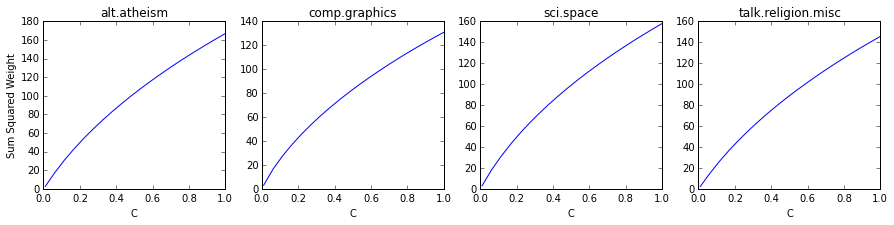

In [5]:
### STUDENT START ###
def P3():
    # use regular vectorizer to get features
    vectorizer = CountVectorizer()
    dtmTrain = vectorizer.fit_transform(train_data)
    dtmDev = vectorizer.transform(dev_data)
        
    # fit knn model
    kRange = range(5, 101, 5)
    print '\nknn - search k in ' + str(kRange)    
    clf = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':kRange})
    clf.fit(dtmTrain, train_labels)    
    print 'knn best k: %d' %clf.best_params_['n_neighbors'] + ', with score: %f ' %clf.best_score_ 
    print 'knn f1 score: %f' %metrics.f1_score(dev_labels, clf.predict(dtmDev))
    
    # fit multinomial NB
    alphaRange = range(1,21,1)
    print '\nMultinomial NB - search alpha in ' + str(alphaRange)
    clf = GridSearchCV(MultinomialNB(), {'alpha':alphaRange})
    clf.fit(dtmTrain, train_labels)
    print 'Multinomial NB best alpha: %f' %clf.best_params_['alpha']     
    print 'Multinomial NB f1 score: %f ' %metrics.f1_score(dev_labels, clf.predict(dtmDev))
        
    # fit logistic regression
    cRange = np.linspace(0.01,1,num=20)
    print '\nLogistic regression - search C in ' + str(cRange)
    clf = GridSearchCV(LogisticRegression(penalty = 'l2'), {'C':cRange})
    clf.fit(dtmTrain, train_labels)
    print 'Logistic regression best C: %f' %clf.best_params_['C']
    print 'Logistic regression f1 score: %f' %metrics.f1_score(dev_labels, clf.predict(dtmDev))
    
    # get sum of squared weight for each C
    print '\nLogistic regression - relation between C and Sum Squared Weight'
    num_labels = len(newsgroups_train.target_names)
    ssw = np.zeros((len(cRange), num_labels))    
    for i in range(len(cRange)):
        lrModel = LogisticRegression(C=cRange[i])
        lrModel.fit(dtmTrain, train_labels)
        ssw[i] = np.sum(lrModel.coef_**2, axis=1)        
    # plot C and sum squared weights
    plt.figure(figsize=(15, 3))
    for i in range(num_labels):
        plt.subplot(1, num_labels, i+1)
        plt.plot(cRange, ssw[:,i])
        plt.title(newsgroups_train.target_names[i])
        plt.xlabel('C')
        if i==0:
            plt.ylabel('Sum Squared Weight')

### STUDENT END ###
P3()

ANSWER:
- a. because the dimension of feature space is high, and the transformed feature vector is very sparse, thus each sample is not very expressive in the feature space. This setup is not good for a distance-based clasifier like knn to perform well.   
- b. one-versus-other modeling setup
- c. as C increases in L1, the penalty on structure complexity decreases, so the weights of each feature will increase.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [6]:
### STUDENT START ###
def EvaluateLogisticRegression(dtmTrain, featureNames, dtmDev):
    # fit logistic regression model    
    lrModel = LogisticRegression(C=1, penalty='l2')
    lrModel.fit(dtmTrain, train_labels)
    nLargest = 5
    nLabel = lrModel.coef_.shape[0]
    weights = lrModel.coef_
    # get index for the largest weight for each label
    dtIndex = np.argpartition(np.abs(weights), -nLargest)[:,-nLargest:]        
    ind = set(np.reshape(dtIndex, (1, nLargest*nLabel))[0])
    # print the table    
    row_format ="{:>20}" * (nLabel + 1)
    print row_format.format("feature", *newsgroups_train.target_names)
    for i in ind:
        print row_format.format(featureNames[i], 
                                *[('* ' if i in dtIndex[j] else '') + '%4f' %weights[j,i] for j in range(nLabel)])
    # check f1 score
    print 'F1 score: %2f' %metrics.f1_score(dev_labels, lrModel.predict(dtmDev))

def P4():
    print '\nFeatures with maximum weights for each label - \'*\' denotes the weight that associates with the label'
    print 'Note: table may not have 20 rows since duplicate features are not printed'
    # use regular vectorizer to get features
    print '\nunigram word feature:'
    vectorizer = CountVectorizer()
    dtmTrain = vectorizer.fit_transform(train_data)
    EvaluateLogisticRegression(dtmTrain, vectorizer.get_feature_names(), vectorizer.transform(dev_data))
    
    # use strict bigram features - no single word
    print '\n(2,2) bigram word feature:'
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))    
    dtmTrain = vectorizer.fit_transform(train_data)
    EvaluateLogisticRegression(dtmTrain, vectorizer.get_feature_names(), vectorizer.transform(dev_data))
    
     # use bigram features - allow single word
    print '\n(1,2) bigram word feature:'
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))   
    dtmTrain = vectorizer.fit_transform(train_data)
    EvaluateLogisticRegression(dtmTrain, vectorizer.get_feature_names(), vectorizer.transform(dev_data))

### STUDENT END ###
P4()


Features with maximum weights for each label - '*' denotes the weight that associates with the label
Note: table may not have 20 rows since duplicate features are not printed

unigram word feature:
             feature         alt.atheism       comp.graphics           sci.space  talk.religion.misc
            graphics           -0.758319          * 1.936720         * -1.336436           -0.762561
            deletion          * 1.125005           -0.398097           -0.420330           -0.396079
               space         * -1.260646         * -1.315897          * 2.162250         * -1.170703
                file           -0.334778          * 1.266551           -0.806797           -0.626243
               blood           -0.533210           -0.106725           -0.316042          * 1.054702
              launch           -0.471193           -0.465420          * 0.936837           -0.332782
           christian           -0.607691           -0.418709           -0.270162          * 1.

ANSWER:
- For unigram feature: most words with maximum weights are closely related to the topic; but for strict bigram: some feature words (e.g. "is there", "and such", "was just", "looking for") are not reflecting the topic at all. 
- This is probably due to those feature words coincidentally appear in the very topic more often than the others, and those features can potentially bring a lot of noise and affect the performance negatively since they are not reflecting the truth - this is validated by the lower f1 score when using strict bigram word feature.
- When we allow single word in bigram feature, the best features are all from single word. This indicates that "bag of words" model works pretty well with this classifier, since the word context doesn't really help improve the performance.


(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [8]:
def empty_preprocessor(s):
    return s

### STUDENT START ###
import nltk
def better_preprocessor(s):
    stemmer = nltk.PorterStemmer()
    # get rid of non-character elements, including numbers
    s = re.sub('[^a-zA-Z]+',' ', s).lower()
    # get rid of words with 1 or 2 characters
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    s = shortword.sub('', s)    
    # stemming
    s = str.join(' ', [stemmer.stem(word) for word in str.split(str(s),' ')])
    return s

### STUDENT END ###

### STUDENT START ###
def P5():
    # no preprocessing
    vectorizer = CountVectorizer(preprocessor=empty_preprocessor)
    dtmTrain = vectorizer.fit_transform(train_data)
    print 'training feature dimsensions with NO preprocessing: %d x %d' %(dtmTrain.shape[0], dtmTrain.shape[1])
    dtmDev = vectorizer.transform(dev_data)
    lrModel = LogisticRegression(C=1)
    lrModel.fit(dtmTrain, train_labels)    
    print 'Logistic regression f1 score: %.3f' %metrics.f1_score(dev_labels, lrModel.predict(dtmDev))

    # using preprocessor
    vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    dtmTrain = vectorizer.fit_transform(train_data)
    print 'training feature dimsensions with preprocessing: %d x %d' %(dtmTrain.shape[0], dtmTrain.shape[1])
    dtmDev = vectorizer.transform(dev_data)    
    lrModel = LogisticRegression(C=1)
    lrModel.fit(dtmTrain, train_labels)
    pred_labels = lrModel.predict(dtmDev)    
    print 'Logistic regression f1 score: %.3f' %metrics.f1_score(dev_labels, pred_labels)
    
    # diagnosis    
    errors = pred_labels != dev_labels
    index = np.array(range(dtmDev.shape[0]))[errors]
    pred_prob = lrModel.predict_proba(dtmDev)[errors]    
#     print index[np.argsort(np.max(pred_prob, axis=1))]
    
### STUDENT END ###
P5()

training feature dimsensions with NO preprocessing: 2034 x 33291
Logistic regression f1 score: 0.702
training feature dimsensions with preprocessing: 2034 x 16513
Logistic regression f1 score: 0.714


In [91]:
s = train_data[90]

import nltk
stemmer = nltk.PorterStemmer()

print s
print '\n---------------------------------------------------------------------\n'
# print re.sub(' +', ' ', re.sub('[0-9]+', '', re.sub('[^a-zA-Z0-9_\'\n\-/ ]+','',crap))).lower()
# remove non letter 
s = re.sub('[^a-zA-Z]+', ' ', s).lower()
shortword = re.compile(r'\W*\b\w{1,3}\b')
s = shortword.sub('', s)

print s
print '\n---------------------------------------------------------------------\n'
print str.join(' ', [stemmer.stem_word(word) for word in str.split(str(s), ' ')])


Yes I am aware CorelDraw exports in SCODAL.
Version 2 did it quite well, apart from a
few hassles with radial fills. Version 3 RevB
is better but if you try to export in SCODAL
with a bitmap image included in the drawing
it will say something like "cannot export
SCODAL with bitmap"- at least it does on my
version.
 If anyone out there knows a way around this
I am all ears.
 Temporal images make a product called Filmpak
which converts Autocad plots to SCODAL, postscript
to SCODAL and now GIF to SCODAL but it costs $650
and I was just wondering if there was anything out
there that just did the bitmap to SCODAL part a tad
cheaper.

---------------------------------------------------------------------

 aware coreldraw exports scodal version quite well apart from hassles with radial fills version revb better export scodal with bitmap image included drawing will something like cannot export scodal with bitmap least does version anyone there knows around this ears temporal images make produc

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

L2 non-zero coefficients: 107516
L2 retain features: 26879
Original L2 accuracy: 0.695

C: 0.001, retained feature: 2, l1 accuracy: 0.331, l2 accuracy: 0.379
C: 0.002, retained feature: 5, l1 accuracy: 0.343, l2 accuracy: 0.428
C: 0.004, retained feature: 12, l1 accuracy: 0.445, l2 accuracy: 0.454
C: 0.009, retained feature: 17, l1 accuracy: 0.470, l2 accuracy: 0.487
C: 0.018, retained feature: 39, l1 accuracy: 0.493, l2 accuracy: 0.581
C: 0.038, retained feature: 88, l1 accuracy: 0.578, l2 accuracy: 0.627
C: 0.078, retained feature: 166, l1 accuracy: 0.627, l2 accuracy: 0.663
C: 0.162, retained feature: 315, l1 accuracy: 0.697, l2 accuracy: 0.682
C: 0.336, retained feature: 561, l1 accuracy: 0.700, l2 accuracy: 0.672
C: 0.695, retained feature: 903, l1 accuracy: 0.703, l2 accuracy: 0.672
C: 1.438, retained feature: 1246, l1 accuracy: 0.703, l2 accuracy: 0.698
C: 2.976, retained feature: 2285, l1 accuracy: 0.700, l2 accuracy: 0.704
C: 6.158, retained feature: 2129, l1 accuracy: 0.694, 

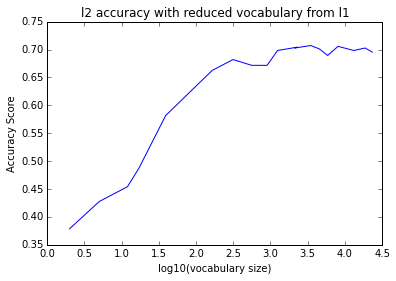

In [9]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    vectorizer = CountVectorizer()
    dtmTrain = vectorizer.fit_transform(train_data)
    dtmDev = vectorizer.transform(dev_data)
    l2Model = LogisticRegression(tol=.01, penalty='l2')
    l2Model.fit(dtmTrain, train_labels)
    print 'L2 non-zero coefficients: %d' %sum(np.sum(l2Model.coef_ != 0, axis=0))
    print 'L2 retain features: %d' %sum(np.sum(l2Model.coef_ != 0, axis=0)>0)
    print 'Original L2 accuracy: %.3f\n' %metrics.accuracy_score(dev_labels, l2Model.predict(dtmDev))
    
    cRange = [10**i for i in np.linspace(-3,3,num=20)]
    accuracy = []
    vocSize = []
    for c in cRange:
        vectorizer = CountVectorizer()
        dtmTrain = vectorizer.fit_transform(train_data)
        dtmDev = vectorizer.transform(dev_data)
        l1Model = LogisticRegression(tol=.01, penalty='l1', C=c)
        l1Model.fit(dtmTrain, train_labels)
        nL1Feas = sum(np.sum(l1Model.coef_ != 0, axis=0)>0)
        l1Accuracy = metrics.accuracy_score(dev_labels, l1Model.predict(dtmDev))
    
        vocabulary = np.array(vectorizer.get_feature_names())
        newVocabulary = vocabulary[np.sum(l1Model.coef_ != 0, axis=0)>0]
        vocSize.append(len(newVocabulary))
        vectorizer = CountVectorizer(vocabulary=newVocabulary)
        dtmTrain = vectorizer.transform(train_data)
        dtmDev = vectorizer.transform(dev_data)
        newL2Model = LogisticRegression(tol=.01, penalty='l2')
        newL2Model.fit(dtmTrain, train_labels)
        l2Accuracy = metrics.accuracy_score(dev_labels, newL2Model.predict(dtmDev))
        accuracy.append(l2Accuracy)
        print 'C: %.3f, retained feature: %d, l1 accuracy: %.3f, l2 accuracy: %.3f' %(c, nL1Feas, l1Accuracy, l2Accuracy)
    
    plt.plot(np.log10(vocSize), accuracy)
    plt.xlabel('log10(vocabulary size)')
    plt.title('l2 accuracy with reduced vocabulary from l1')
    plt.ylabel('Accuracy Score')
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [21]:
def P7():
    ### STUDENT START ###
    tVectorizer = TfidfVectorizer(max_df=0.71)
    dtmTrain = tVectorizer.fit_transform(train_data)
    dtmDev = tVectorizer.transform(dev_data)
    #  train logistic regression model with C=100
    lrModel = LogisticRegression(C=100, penalty='l2')
    lrModel.fit(dtmTrain, train_labels)
    # make predictions on dev data
    prediction = lrModel.predict(dtmDev)
    print 'L2 vocabulary size: %d' %dtmDev.shape[0]
    print 'f1 score with TfidfVectorizer: %f' %metrics.f1_score(dev_labels, prediction)
    print confusion_matrix(dev_labels, prediction)
    # find index for correct label
    correct = prediction==dev_labels
    clIndex = np.array(range(dtmDev.shape[0]))[correct]
    # get predicted probability
    pp = lrModel.predict_proba(dtmDev)    
    # get predicted probabilities of the correct label    
    ppcl = pp[correct]
    # get maximum predicted probability
    mpp = max(np.max(pp, axis=1))
    print 'Maximum predicted probability: %f' %mpp
    # get R
    R = np.array([mpp/max(ppc) for ppc in ppcl])
    # find document ID for the top 3 R
    sortIndex = np.argsort(R)
    n=3
    print '\nIndex of top %d documents with largest R: %s' %(n, str(clIndex[sortIndex[-n:]]))
    # print the documents
    for i in sortIndex[-n:][::-1]:
        label = newsgroups_test.target_names[dev_labels[clIndex[i]]]
        print '\nDocument #%d, R: %.3f, label: %s' %(clIndex[i], R[i], label)
        print dev_data[clIndex[i]]
    
    # diagonosing mistakes
    wrongIndex = np.array(range(dtmDev.shape[0]))[~correct]
    ppwl = pp[~correct]
    sortIndex = np.argsort(np.max(ppwl, axis=1))
    i = sortIndex[-1]
    origLabel = newsgroups_test.target_names[dev_labels[wrongIndex[i]]]
    predLabel = newsgroups_test.target_names[prediction[wrongIndex[i]]]
    print '\noriginal topic: %s, prediction: %s\n' %(origLabel, predLabel)
#     print ppwl[i,:]
    print dev_data[wrongIndex[i]]    
    
    ### STUDENT END ###
P7()

L2 vocabulary size: 676
f1 score with TfidfVectorizer: 0.771259
[[105   4  22  34]
 [  6 165  13   1]
 [ 12  11 172   4]
 [ 30   6  10  81]]
Maximum predicted probability: 0.999985

Index of top 3 documents with largest R: [ 74 238 336]

Document #336, R: 3.526, label: sci.space

----------

Document #238, R: 3.526, label: sci.space


Document #74, R: 3.526, label: sci.space


original topic: talk.religion.misc, prediction: comp.graphics

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous annou

ANSWER:
- set parameter of the vectorizer?
- check misspelling
- pairwise comparison
- compare 0 & 3 specifically - anything was classified as 0 or 3, will run through a separate LR model

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [46]:
# do a pairwise comparison
# TODO: evaluate all pairwise model, then ensemble them
print [sum(train_labels==i) for i in range(4)]
pairs = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

# train n*(n-1)/2 pairwise models
models = []
vectorizers = []

trainData = np.array(train_data)

for pair in pairs:
    picker = np.in1d(train_labels,pair)    
    labels = train_labels[picker]
    data = trainData[picker]
    vectorizer = CountVectorizer()
    dtmTrain = vectorizer.fit_transform(data)
    
    print dtmTrain.shape
    model = LogisticRegression(penalty='l2')
    
    model.fit(dtmTrain, labels)
    models.append(model)
    vectorizers.append(vectorizer)

# prediction
pred_prob = np.zeros(shape=(len(dev_labels), len(newsgroups_test.target_names)))
for vectorizer,model,pair in zip(vectorizers,models,pairs):
    dtmDev = vectorizer.transform(dev_data)
    pred_p = model.predict_proba(dtmDev)
    for i in range(len(pair)):
        pred_prob[:, pair[i]] = pred_prob[:, pair[i]] + pred_p[:,i]
    
prediction = np.argmax(pred_prob, axis=1)
# print np.sum(pred_prob, axis=1)
print metrics.f1_score(dev_labels, prediction)
print confusion_matrix(dev_labels, prediction)

print '\nanother attemp - only compare 0 and 3'
picker = np.in1d(train_labels, [0,3])
data = np.array(train_data)[picker]
labels = train_labels[picker]
vectorizer = CountVectorizer()
dtmTrain = vectorizer.fit_transform(data)
print dtmTrain.shape
model = LogisticRegression(C=1)
model.fit(dtmTrain, labels)

picker = np.in1d(dev_labels, [0,3])
data = np.array(dev_data)[picker]
labels = dev_labels[picker]
dtmDev = vectorizer.transform(data)
print model.score(dtmDev, labels)
print confusion_matrix(labels, model.predict(dtmDev))

[480, 584, 593, 377]
(1064, 16464)
(1073, 18217)
(857, 13683)
(1177, 19493)
(961, 16646)
(970, 18453)
0.686511517913
[[ 93  11  23  38]
 [  9 156  18   2]
 [ 13  20 160   6]
 [ 42  10  16  59]]

another attemp - only compare 0 and 3
(857, 13683)
0.650684931507
[[113  52]
 [ 50  77]]
